In [11]:
%reload_ext autoreload
%autoreload 2
# allow iterative matplotlib plots
%matplotlib widget
# %matplotlib inline

from IPython import display
import sys, os
sys.path.append(os.path.join(os.getcwd(),'..','..'))

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib import gridspec
import scipy as sp

from CBOSS.bayesian_models.regression import StudentTProcessRegression
from CBOSS.bayesian_models.classification import LaplaceGaussianProcessClassification
from CBOSS.bayesian_models.kernels import PolynomialKernel, CombKernel, DiscreteDiffusionKernel, HammingKernel, RBFKernel
from CBOSS.bayesian_models.acquisitions import FRCHEI, hierarchical_expected_improvement


## Init true function and measurements

In [12]:
f_true = lambda x: torch.cos(1 * torch.pi * x) * 2.0
g_true = lambda x: torch.tanh(x*2)
h_true = lambda x:  ((x < 1) * (x > -2)).to(int)

# set pytorch seed
torch.manual_seed(124)
torch.manual_seed(3523)

X_range = [-2,2]

N = 15
X = torch.rand(N, 1, dtype=torch.double) * (X_range[1]-X_range[0]) - (X_range[1]-X_range[0])/2
X = torch.tensor([-1.5, -1.4, -1.39, -0.5, -0.4, -0.0, 0.1, 0.11, 0.2, 0.8, 1.0, 1.1, 1.15, 1.3, 1.4])[:,None]

X_pred = torch.linspace(*X_range, 1000, dtype=torch.double)[:,None]

y = f_true(X)[:,0]
c = g_true(X)[:,0]
l = h_true(X)[:,0]

# failures hinder the assessment of the objective and constraint functions
y[l==0] = torch.nan
c[l==0] = torch.nan

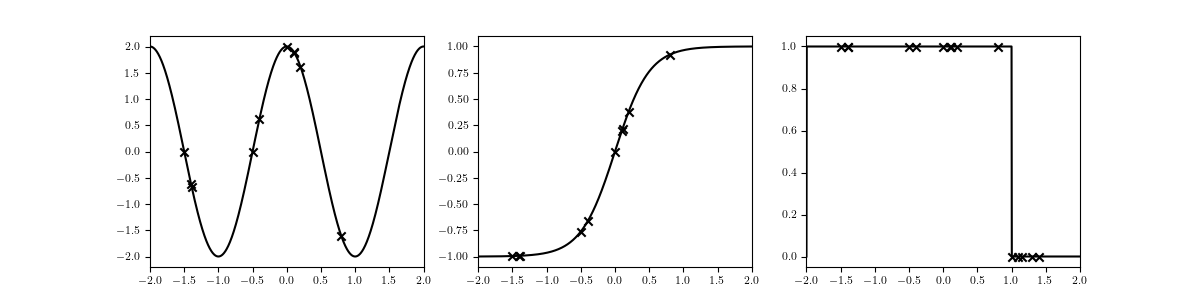

In [13]:
# plot data
fig,axs = plt.subplots(1,3,figsize=(12,3))
# 
axs[0].scatter(X[:,0], y, marker='x', color='k')
axs[0].plot(X_pred[:,0], f_true(X_pred)[:,0], color='k')
axs[0].set_xlim(X_range)
# 
axs[1].scatter(X[:,0], c, marker='x', color='k')
axs[1].plot(X_pred[:,0], g_true(X_pred)[:,0], color='k')
axs[1].set_xlim(X_range)
# 
axs[2].scatter(X[:,0], l, marker='x', color='k')
axs[2].plot(X_pred[:,0], h_true(X_pred)[:,0], color='k')
axs[2].set_xlim(X_range)
# plt.tight_layout()
plt.show()

## Train probabilistic models

In [14]:
sigma2 = 0.02
ls = 0.4

f_surr = StudentTProcessRegression(
    X = X,
    y = y,
    kernel = RBFKernel(length_scales=ls, variance_prior=1.0/sigma2),
    train_sigma2 = False,
    sigma2m_prior = sigma2,
).double()
f_surr.eval()

g_surr = StudentTProcessRegression(
    X = X,
    y = c,
    kernel = RBFKernel(length_scales=ls, variance_prior=1.0/sigma2),
    train_sigma2 = False,
    sigma2m_prior = sigma2
).double()
g_surr.eval()

ls = 0.6

h_surr = LaplaceGaussianProcessClassification(
    X = X, 
    y = l, 
    kernel = RBFKernel(length_scales=ls, variance_prior=10.),
).double()

h_surr.train()
opt_state = h_surr.fit(lr=1.0, maxiter=1, maxevals_per_iter=int(1e3))
h_surr.eval()



======== GPClass. train report ===========
	Time elapsed: 0.0 s
	nbr evals:      22
	residual_delta: 8.5e-04
	residual_g:     8.7e-08

	K.variance_prior               : [10.00] -> [10.00]
	K.length_scales                : [0.60] -> [0.60]
==== ENDOF GPClass. train report ===========



## Evaluate Acquisition function

In [15]:
y_pred = f_surr(X_pred)
c_pred = g_surr(X_pred)
l_pred = h_surr(X_pred)

In [16]:
y_feas_best = torch.min(y[(c <= 0) & ~(torch.isnan(y))])

In [17]:
HEI = hierarchical_expected_improvement(y_post=y_pred, y_best=y_feas_best)

Pfeas = torch.Tensor([
    sp.stats.t(df=c_pred.df, loc=m, scale=std).cdf(0.0)
    for m,std in zip(c_pred.mean, c_pred.variance**0.5)
])
Psucc =  l_pred.mean
FRCHEI = Psucc * Pfeas * HEI

## Plot

In [18]:
plt.close('all')

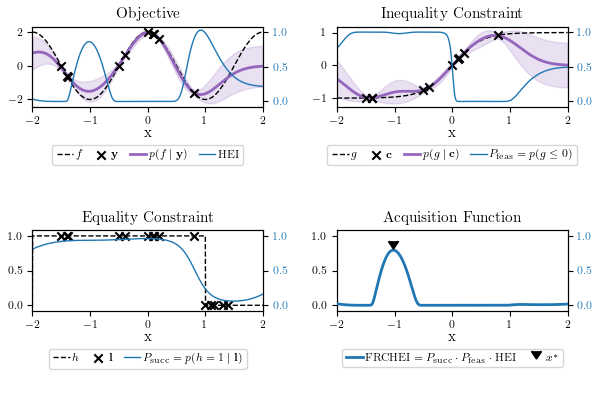

In [19]:
def confidence_plot(ax, x, loc, std, *args, **kwargs):
    ax.fill_between(x=x, y1=loc+std, y2=loc-std, *args, **kwargs)

import matplotlib

# change color of right y-axis to tab:blue

''' Paper Settings
'''
# grid = False
# fig_cells = (1,4)
# cell_size = (4,3.2)
# matplotlib.rcParams.update({
#     'font.size': 11, 
#     'legend.fontsize': 14, 
#     'axes.titlesize': 18,
#     'xtick.labelsize': 8,
#     'ytick.labelsize': 8,
#     'text.usetex': True
# })

grid = False
fig_cells = (2,2)
figsize = (6.5,2.)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 8, 
    'axes.titlesize': 8,
    'legend.fontsize': 8, 
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.labelpad': 0,
    'axes.titlepad': 5,
})
tight_layout_args = dict(
    pad   = 0.0, 
    w_pad = 0.5, 
    h_pad = 0.0,
    rect=[0.2, 0, 1.0, 1.0]
)
legend_args = dict(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.4),
    # bbox_to_anchor=(0.5, 1.32), 
    ncol=4, 
    columnspacing=1.2, labelspacing=0.5, handletextpad=0.2, handlelength=1.5,
)


''' Thesis Settings
'''
grid = False
fig_cells = (2,2)
figsize = (6,4)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 11, 
    'axes.titlesize': 11,
    'legend.fontsize': 8, 
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.labelpad': 0,
})
tight_layout_args = dict(
    pad   = 0.5, 
    w_pad = 1.0, 
    h_pad = 1.5
)
legend_args = dict(
    loc='upper center', bbox_to_anchor=(0.5, -0.40), ncol=4, 
    columnspacing=1.0, labelspacing=0.5, handletextpad=0.2, handlelength=1.5,
)

''' PLOT
'''

# plot data
fig,axs = plt.subplots(*fig_cells,figsize=figsize)
axs = axs.reshape(2,2)

''' OBJECTIVE FUNCTION
'''
ax = axs[0,0]
axr = ax.twinx()
ax.plot(X_pred[:,0], f_true(X_pred)[:,0], color='k', linewidth=1.0, alpha=1.0, linestyle='--', label=r'$f$')
ax.scatter(X[:,0], y, marker='x', color='k', zorder=99, label=r'$\mathbf y$')
confidence_plot( ax, x=X_pred[:,0], loc=y_pred.loc, std=y_pred.variance**0.5, alpha=0.2, color='tab:purple')
ax.plot(X_pred, y_pred.loc, color='tab:purple', linewidth=2.0, label=r"$p(f \mid \mathbf y)$")
axr.plot(X_pred[:,0], HEI, color='tab:blue', linewidth=1.0, label=r'$\mathrm{HEI}$')
# 
# axr.set_yticks([])
axr.tick_params(axis ='y', labelcolor = 'tab:blue')
axr.set_ylim([-0.08,1.08])
# 
ax.set_xlim(X_range)
ax.set_xlabel('x')
ax.set_title('Objective')
# ax.set_ylabel('f(x)')
h1,l1 = ax.get_legend_handles_labels()
h2,l2 = axr.get_legend_handles_labels()
leg = ax.legend(h1+h2, l1+l2, **legend_args)
if grid:
    ax.grid()

''' INEQUALITY CONSTRAINT
'''
ax = axs[0,1]
axr = ax.twinx()
ax.plot(X_pred[:,0], g_true(X_pred)[:,0], color='k', linewidth=1.0, alpha=1.0, linestyle='--', label=r'$g$')
ax.scatter(X[:,0], c, marker='x', color='k', zorder=99, label=r'$\mathbf c$')
confidence_plot( ax, x=X_pred[:,0], loc=c_pred.loc, std=c_pred.variance**0.5, alpha=0.2, color='tab:purple')
ax.plot(X_pred, c_pred.loc, color='tab:purple', linewidth=2.0, label=r"$p(g \mid \mathbf c)$")
axr.plot(X_pred[:,0], Pfeas, color='tab:blue', linewidth=1.0, label=r'$P_{\mathrm{feas}} = p(g \leq 0)$')
# 
# axr.set_yticks([])
axr.tick_params(axis ='y', labelcolor = 'tab:blue')
axr.set_ylim([-0.08,1.08])
# 
ax.set_xlim(X_range)
ax.set_xlabel('x')
ax.set_title('Inequality Constraint')
# ax.set_ylabel('g(x)')
h1,l1 = ax.get_legend_handles_labels()
h2,l2 = axr.get_legend_handles_labels()
leg = ax.legend(h1+h2, l1+l2, **legend_args)
if grid:
    ax.grid()

''' EQUALITY CONSTRAINT
'''
ax = axs[1,0]
axr = ax.twinx()
# axr = ax.twinx()
ax.plot(X_pred[:,0], h_true(X_pred)[:,0], color='k', linewidth=1.0, alpha=1.0, linestyle='--', label=r'$h$')
ax.scatter(X[:,0], l, marker='x', color='k', zorder=99, label=r'$\mathbf l$')
# ax.plot(X_pred, l_pred, color='tab:purple', linewidth=2.0, label=r"$p(h = 1 \mid \mathbf l)$")
# ax.plot(X_pred, 1 - l_pred, color='tab:blue', linewidth=1.0, label=r'$P_{fail} = p(h = 0)$')
axr.plot(X_pred, l_pred.mean, color='tab:blue', linewidth=1.0, label=r"$P_{\mathrm{succ}} = p(h = 1 \mid \mathbf l)$")
# 
# axr.set_yticks([])
axr.tick_params(axis ='y', labelcolor = 'tab:blue')
axr.set_ylim([-0.08,1.08])
# 
ax.set_xlim(X_range)
ax.set_ylim([-0.08,1.08])
ax.set_xlabel('x')
ax.set_title('Equality Constraint')
# ax.set_ylabel('h(x)')
h1,l1 = ax.get_legend_handles_labels()
h2,l2 = axr.get_legend_handles_labels()
leg = ax.legend(
    h1+h2, l1+l2, **legend_args
)
if grid:
    ax.grid()

''' ACQUISITION FUNCTION
'''
ax = axs[1,1]
axr = ax.twinx()
# ax.plot(X_pred[:,0], HEI, color='tab:blue', linewidth=1.0, label='HEI', alpha=0.5)
# ax.plot(X_pred[:,0], Pfeas, color='tab:blue', linewidth=1.0, label=r'$P_{feas}=p(g(x)\leq 0)$', alpha=0.5)
# ax.plot(X_pred, l_pred, color='tab:blue', linewidth=1.0, label=r'$P_{fail} = p(h(x) = 1)$', alpha=0.5)
axr.plot(X_pred, FRCHEI, color='tab:blue', linewidth=2.0, label=r'$\mathrm{FRCHEI} = P_{\mathrm{succ}} \cdot P_{\mathrm{feas}} \cdot \mathrm{HEI}$', zorder=10)
# plot x_best at the top of FRCHEI with a triangle marker pointing down, marker size 20
axr.scatter(X_pred[FRCHEI.argmax()], FRCHEI.max()+0.03, marker=7, color='k', zorder=99, s=50, label=r'$x^*$')
axr.scatter(X_pred[FRCHEI.argmax()], FRCHEI.max()+0.05, marker=7, color='k', zorder=99, s=50, alpha=0.)
# 
axr.tick_params(axis ='y', labelcolor = 'tab:blue')
axr.set_ylim([-0.08,1.08])
# 
ax.set_xlim(X_range)
ax.set_ylim([-0.08,1.08])
ax.set_xlabel('x')
ax.set_title('Acquisition Function')
# 
h1,l1 = ax.get_legend_handles_labels()
h2,l2 = axr.get_legend_handles_labels()
leg = ax.legend(h1+h2, l1+l2, **legend_args)
if grid:
    ax.grid()

plt.tight_layout(**tight_layout_args)
# plt.tight_layout(pad=0.0, w_pad=0.2, h_pad=0.)
# plt.tight_layout(pad=0.0, w_pad=1.0, h_pad=1.0)

plt.show()
# save figure
fig.savefig('images/FRCHEI.png', bbox_inches='tight')
fig.savefig('images/FRCHEI.pdf', bbox_inches='tight')